# Wind turbine inspection efficiency with Artificial Intelligence

This script was developed as part of the Final Course Work in MBA in Data Science and Analytics at Universidade de São Paulo - Escola Superior de Agricultura Luiz de Queiroz.

In [143]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor as DTRegressor
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.ensemble import AdaBoostRegressor as Ada
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Exploratory Data Analysis

In [144]:
# Read the dataset
df = pd.read_csv('/content/Wind Turbine Power Prediction.csv')

In [145]:
# View the first five lines
df.head(5)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [146]:
# Rename column headers
df.columns = ['date', 'active_power', 'wind_speed', 'theor_power', 'wind_dir']

In [147]:
# Convert 'date' column to datetime objects, specifying dayfirst=True and the format
df['date'] = pd.to_datetime(df['date'], format='%d %m %Y %H:%M', dayfirst=True)


In [148]:
# Preview the header again
df.head(5)

,date,active_power,wind_speed,theor_power,wind_dir
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [149]:
# Set the datetime column as the index
df.set_index('date', inplace=True)

In [150]:
# Get descriptive statistics from the data and save as a sheet
statistics = df.describe()
statistics.to_excel('statistics.xlsx', index = True)
statistics

,active_power,wind_speed,theor_power,wind_dir
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [151]:
# Get hours from datetime
dates = df.index
hours = [date.hour for date in dates]
df['hour'] = hours

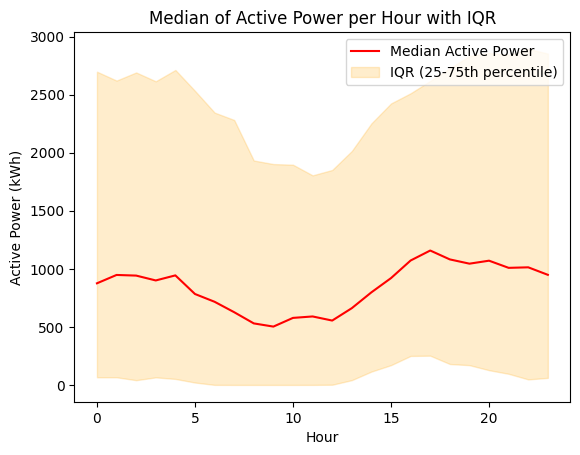

In [152]:
# Group by 'hour' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped = df.groupby('hour')['active_power'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['median', 'Q1', 'Q3']

# Create the plot for median active power
plt.plot(grouped.index, grouped['median'], label='Median Active Power', color='red')

# Shade the IQR (Q3 - Q1) region
plt.fill_between(grouped.index, grouped['Q1'], grouped['Q3'], color='orange', alpha=0.2, label='IQR (25-75th percentile)')

# Adding titles and labels
plt.title('Median of Active Power per Hour with IQR')
plt.xlabel('Hour')
plt.ylabel('Active Power (kWh)')
plt.legend()

# Save the graphic
plt.savefig('active_power_median_per_hour.png', dpi = 600)

# Show the plot
plt.show()

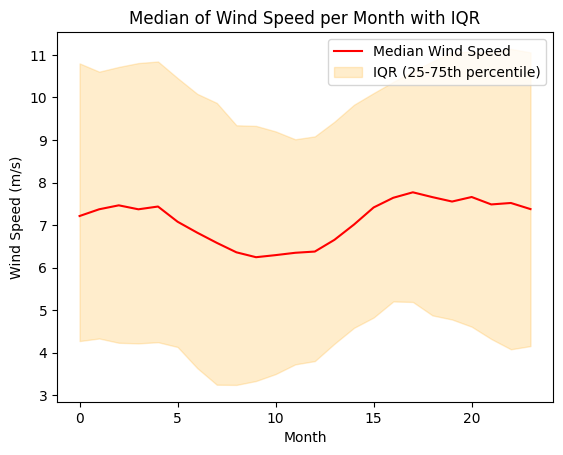

In [153]:
# Group by 'hour' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped = df.groupby('hour')['wind_speed'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['median', 'Q1', 'Q3']

# Create the plot for median wind speed
plt.plot(grouped.index, grouped['median'], label='Median Wind Speed', color='red')

# Shade the IQR (Q3 - Q1) region
plt.fill_between(grouped.index, grouped['Q1'], grouped['Q3'], color='orange', alpha=0.2, label='IQR (25-75th percentile)')

# Adding titles and labels
plt.title('Median of Wind Speed per Month with IQR')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.legend()

# Save the graphic
plt.savefig('wind_speed_median_per_hour.png', dpi = 600)

# Show the plot
plt.show()

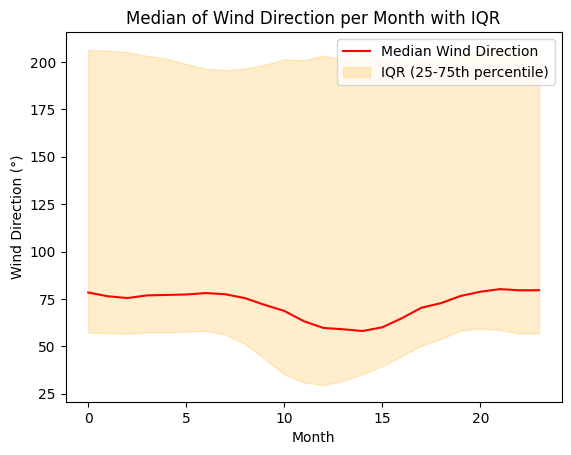

In [154]:
# Group by 'hour' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped = df.groupby('hour')['wind_dir'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['median', 'Q1', 'Q3']

# Create the plot for median wind direction
plt.plot(grouped.index, grouped['median'], label='Median Wind Direction', color='red')

# Shade the IQR (Q3 - Q1) region
plt.fill_between(grouped.index, grouped['Q1'], grouped['Q3'], color='orange', alpha=0.2, label='IQR (25-75th percentile)')

# Adding titles and labels
plt.title('Median of Wind Direction per Month with IQR')
plt.xlabel('Month')
plt.ylabel('Wind Direction (°)')
plt.legend()

# Save the graphic
plt.savefig('wind_dir_median_per_hour.png', dpi = 600)

# Show the plot
plt.show()

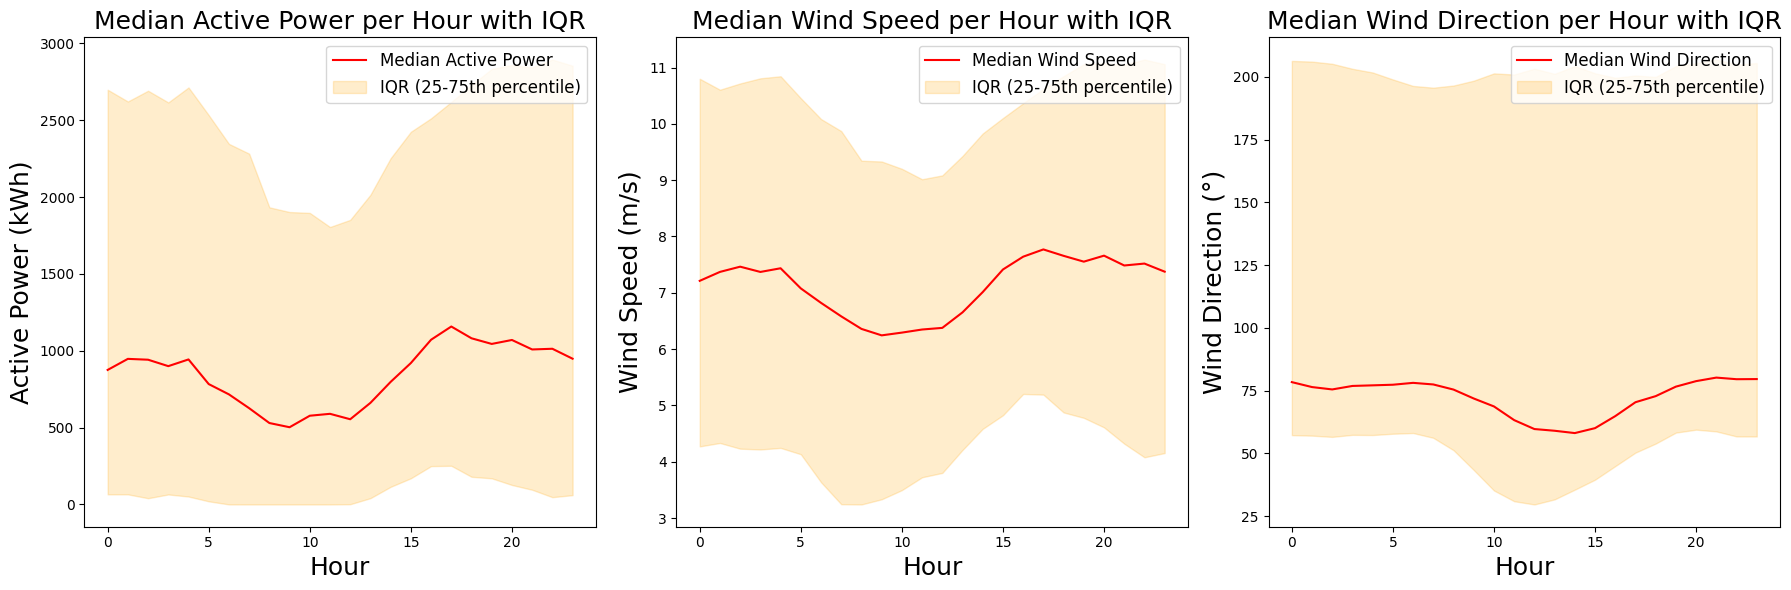

In [155]:
# Plot the last three graphs together

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# ---- Graph 1: Active Power ----
# Group by hour and calculate median, Q1 and Q3 for active power
grouped_power = df.groupby('hour')['active_power'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped_power.columns = ['median', 'Q1', 'Q3']

# Plot in the first subplot
axes[0].plot(grouped_power.index, grouped_power['median'], label='Median Active Power', color='red')
axes[0].fill_between(grouped_power.index, grouped_power['Q1'], grouped_power['Q3'], color='orange', alpha=0.2, label='IQR (25-75th percentile)')
axes[0].set_title('Median Active Power per Hour with IQR', fontsize=18)
axes[0].set_xlabel('Hour', fontsize=18)
axes[0].set_ylabel('Active Power (kWh)', fontsize=18)
axes[0].legend(fontsize=12)

# ---- Graph 2: Wind Speed ----
# Group by hour and calculate median, Q1 and Q3 for active power
grouped_speed = df.groupby('hour')['wind_speed'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped_speed.columns = ['median', 'Q1', 'Q3']

# Plot in second subplot
axes[1].plot(grouped_speed.index, grouped_speed['median'], label='Median Wind Speed', color='red')
axes[1].fill_between(grouped_speed.index, grouped_speed['Q1'], grouped_speed['Q3'], color='orange', alpha=0.2, label='IQR (25-75th percentile)')
axes[1].set_title('Median Wind Speed per Hour with IQR', fontsize=18)
axes[1].set_xlabel('Hour', fontsize=18)
axes[1].set_ylabel('Wind Speed (m/s)', fontsize=18)
axes[1].legend(fontsize=12)

# ---- Graph 3: Wind Direction ----
# Group by hour and calculate median, Q1 and Q3 for active power
grouped_dir = df.groupby('hour')['wind_dir'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped_dir.columns = ['median', 'Q1', 'Q3']

# Plot in the third subplot
axes[2].plot(grouped_dir.index, grouped_dir['median'], label='Median Wind Direction', color='red')
axes[2].fill_between(grouped_dir.index, grouped_dir['Q1'], grouped_dir['Q3'], color='orange', alpha=0.2, label='IQR (25-75th percentile)')
axes[2].set_title('Median Wind Direction per Hour with IQR', fontsize=18)
axes[2].set_xlabel('Hour', fontsize=18)
axes[2].set_ylabel('Wind Direction (°)', fontsize=18)
axes[2].legend(fontsize=12)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Save the graphic
plt.savefig('median_per_hour.png', dpi = 600)

# Show the figure with the three graphs
plt.show()


In [156]:
# Get months from datetime
dates = df.index
months = [date.month for date in dates]
df['month'] = months
df

,active_power,wind_speed,theor_power,wind_dir,hour,month
date,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1
...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12


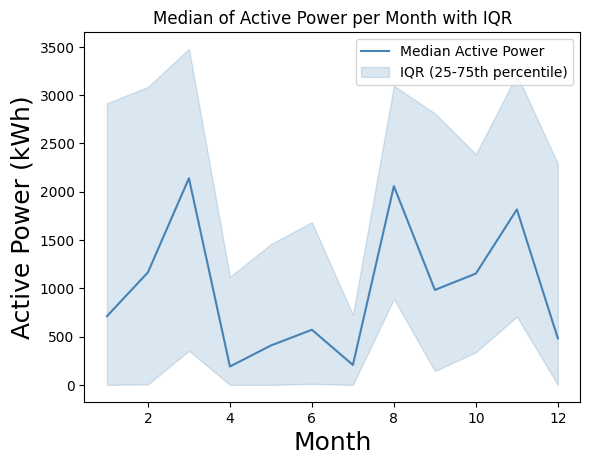

In [157]:
# Group by 'month' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped = df.groupby('month')['active_power'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['median', 'Q1', 'Q3']

# Create the plot for median active power
plt.plot(grouped.index, grouped['median'], label='Median Active Power', color='steelblue')

# Shade the IQR (Q3 - Q1) region
plt.fill_between(grouped.index, grouped['Q1'], grouped['Q3'], color='steelblue', alpha=0.2, label='IQR (25-75th percentile)')

# Adding titles and labels
plt.title('Median of Active Power per Month with IQR')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Active Power (kWh)', fontsize=18)
plt.legend()

# Save the graphic
plt.savefig('active_power_median_per_month.png', dpi = 600)

# Show the plot
plt.show()


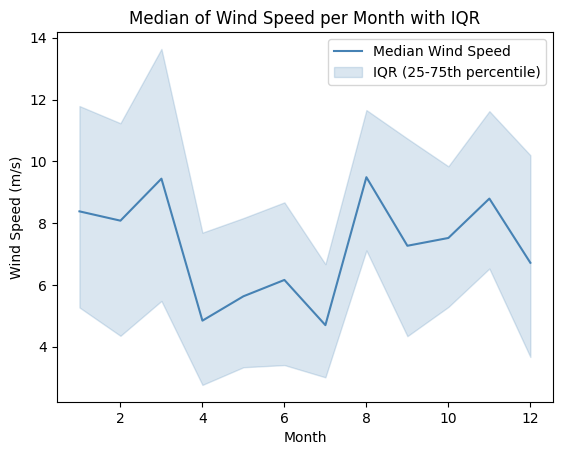

In [158]:
# Group by 'month' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped = df.groupby('month')['wind_speed'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['median', 'Q1', 'Q3']

# Create the plot for median wind speed
plt.plot(grouped.index, grouped['median'], label='Median Wind Speed', color='steelblue')

# Shade the IQR (Q3 - Q1) region
plt.fill_between(grouped.index, grouped['Q1'], grouped['Q3'], color='steelblue', alpha=0.2, label='IQR (25-75th percentile)')

# Adding titles and labels
plt.title('Median of Wind Speed per Month with IQR')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.legend()

# Save the graphic
plt.savefig('wind_speed_median_per_month.png', dpi = 600)

# Show the plot
plt.show()


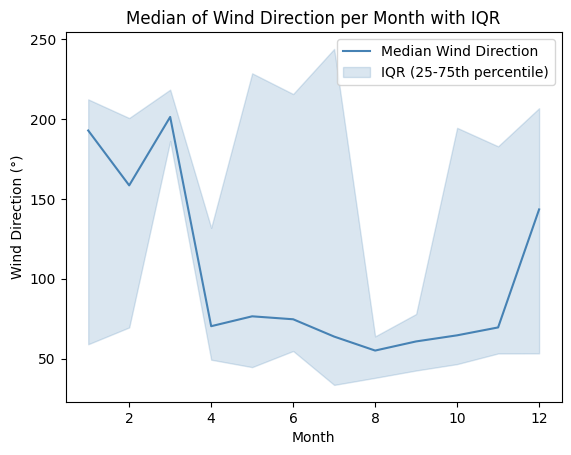

In [159]:
# Group by 'month' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped = df.groupby('month')['wind_dir'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['median', 'Q1', 'Q3']

# Create the plot for median wind direction
plt.plot(grouped.index, grouped['median'], label='Median Wind Direction', color='steelblue')

# Shade the IQR (Q3 - Q1) region
plt.fill_between(grouped.index, grouped['Q1'], grouped['Q3'], color='steelblue', alpha=0.2, label='IQR (25-75th percentile)')

# Adding titles and labels
plt.title('Median of Wind Direction per Month with IQR')
plt.xlabel('Month')
plt.ylabel('Wind Direction (°)')
plt.legend()

# Save the graphic
plt.savefig('wind_dir_median_per_month.png', dpi = 600)

# Show the plot
plt.show()

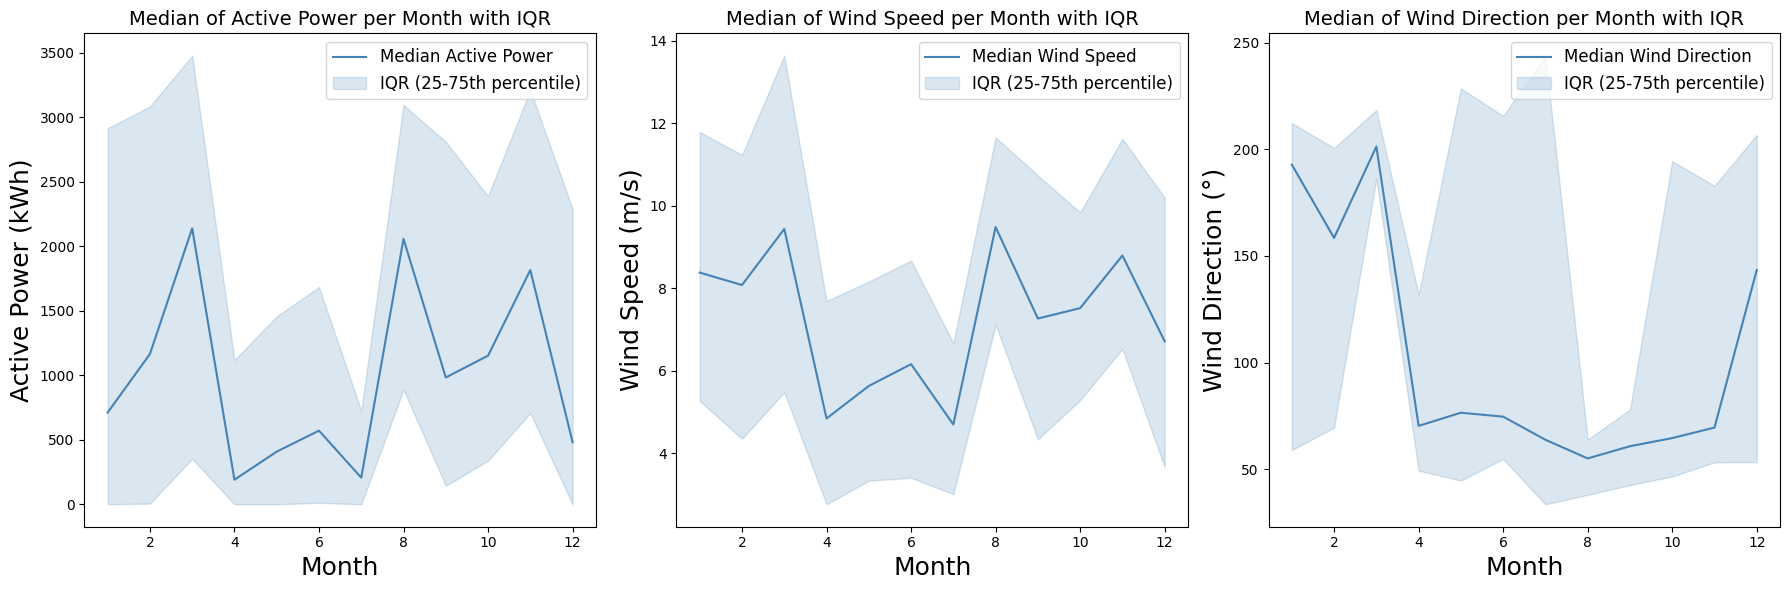

In [160]:
# Plot the last three graphs together


# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# ---- Plot 1: Active Power ----
# Group by 'month' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped_power = df.groupby('month')['active_power'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped_power.columns = ['median', 'Q1', 'Q3']

# Plot the median active power in the first subplot
axes[0].plot(grouped_power.index, grouped_power['median'], label='Median Active Power', color='steelblue')
axes[0].fill_between(grouped_power.index, grouped_power['Q1'], grouped_power['Q3'], color='steelblue', alpha=0.2, label='IQR (25-75th percentile)')
axes[0].set_title('Median of Active Power per Month with IQR', fontsize=14)
axes[0].set_xlabel('Month', fontsize=18)
axes[0].set_ylabel('Active Power (kWh)', fontsize=18)
axes[0].legend(fontsize=12)

# ---- Plot 2: Wind Speed ----
# Group by 'month' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped_speed = df.groupby('month')['wind_speed'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped_speed.columns = ['median', 'Q1', 'Q3']

# Plot the median wind speed in the second subplot
axes[1].plot(grouped_speed.index, grouped_speed['median'], label='Median Wind Speed', color='steelblue')
axes[1].fill_between(grouped_speed.index, grouped_speed['Q1'], grouped_speed['Q3'], color='steelblue', alpha=0.2, label='IQR (25-75th percentile)')
axes[1].set_title('Median of Wind Speed per Month with IQR', fontsize=14)
axes[1].set_xlabel('Month', fontsize=18)
axes[1].set_ylabel('Wind Speed (m/s)', fontsize=18)
axes[1].legend(fontsize=12)

# ---- Plot 3: Wind Direction ----
# Group by 'month' and calculate the median, 25th percentile (Q1), and 75th percentile (Q3)
grouped_dir = df.groupby('month')['wind_dir'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped_dir.columns = ['median', 'Q1', 'Q3']

# Plot the median wind direction in the third subplot
axes[2].plot(grouped_dir.index, grouped_dir['median'], label='Median Wind Direction', color='steelblue')
axes[2].fill_between(grouped_dir.index, grouped_dir['Q1'], grouped_dir['Q3'], color='steelblue', alpha=0.2, label='IQR (25-75th percentile)')
axes[2].set_title('Median of Wind Direction per Month with IQR', fontsize=14)
axes[2].set_xlabel('Month', fontsize=18)
axes[2].set_ylabel('Wind Direction (°)', fontsize=18)
axes[2].legend(fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the graphic
plt.savefig('median_per_month.png', dpi = 600)

# Display the figure with three side-by-side plots
plt.show()




In [161]:
# Calculate power loss
df['loss'] = df['theor_power'] - df['active_power']

In [162]:
# Describe the power loss data
df['loss'].describe()

,loss
count,50530.000000
mean,184.491131
std,427.701555
min,-598.741011
25%,0.000000
50%,66.682623
75%,194.562692
max,3600.000000


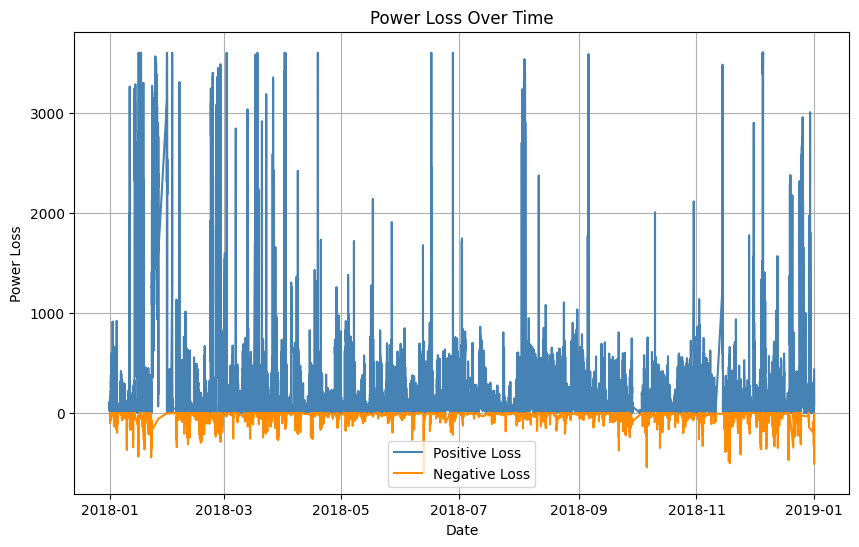

In [163]:
# Create the plot for power loss
plt.figure(figsize=(10, 6))

# Plot positive values ​​with blue color
plt.plot(df.index[df['loss'] >= 0], df['loss'][df['loss'] >= 0], color='steelblue', label='Positive Loss')

# Plot negative values with orange color
plt.plot(df.index[df['loss'] < 0], df['loss'][df['loss'] < 0], color='darkorange', label='Negative Loss')

plt.xlabel('Date')
plt.ylabel('Power Loss')
plt.title('Power Loss Over Time')
plt.legend()
plt.grid(True)

# Save the graphic
plt.savefig('power_loss.png', dpi = 600)

# Show the plot
plt.show()



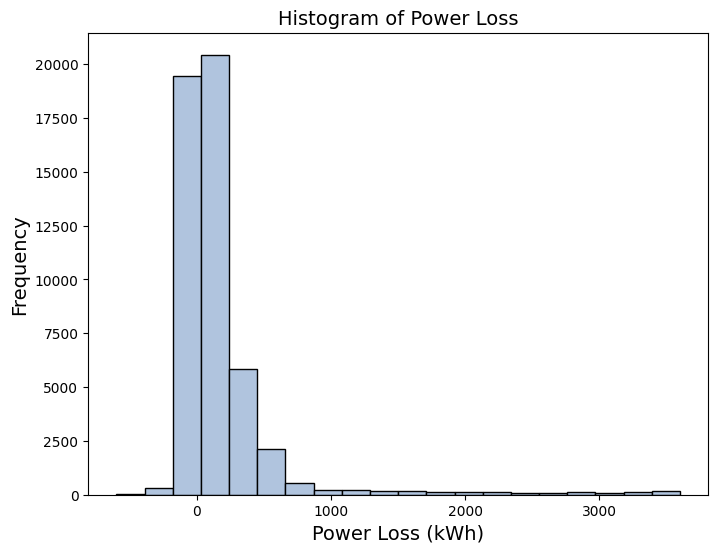

In [164]:
# Plot a histogram of power loss values

plt.figure(figsize=(8, 6))
plt.hist(df['loss'], bins=20, color='lightsteelblue', edgecolor='black')
plt.xlabel('Power Loss (kWh)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of Power Loss', fontsize = 14)
plt.show()

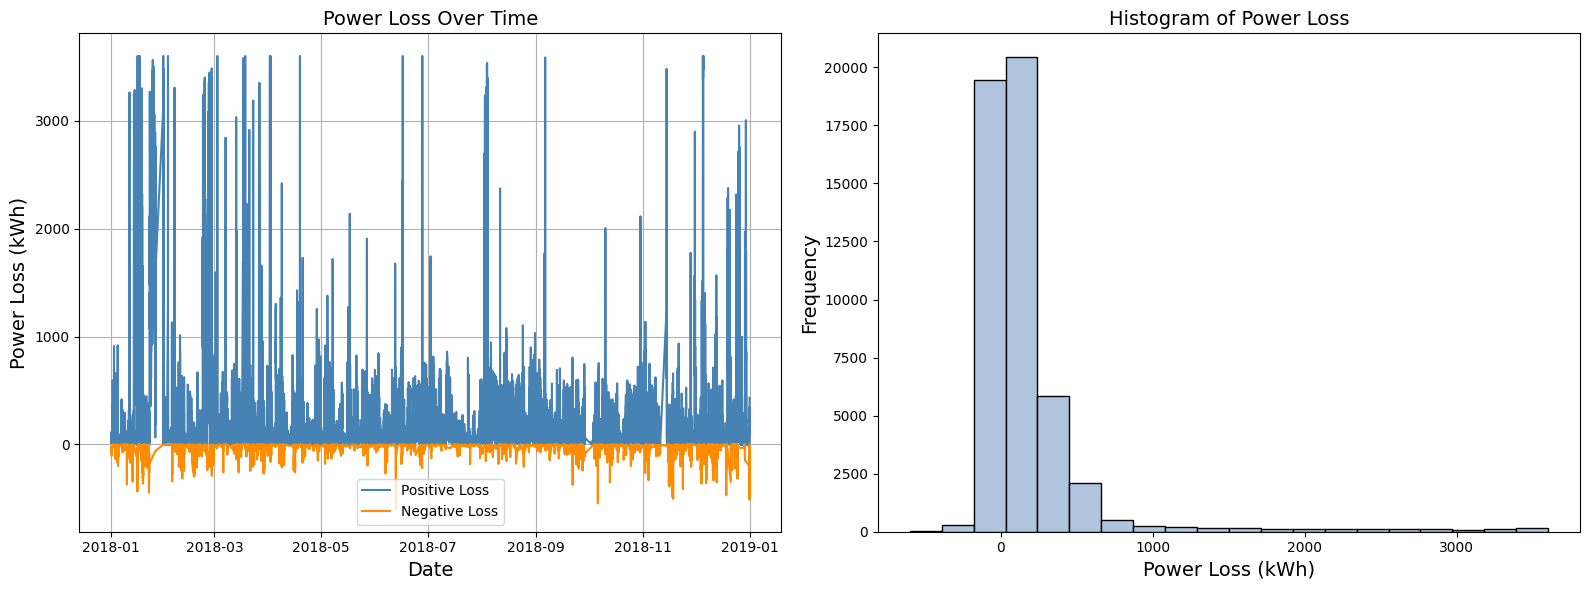

In [165]:
# Plot the last two graphs together

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Subplot 1: Power loss over time ----
# Plot positive values ​​with blue color
axes[0].plot(df.index[df['loss'] >= 0], df['loss'][df['loss'] >= 0], color='steelblue', label='Positive Loss')

# Plot negative values with orange color
axes[0].plot(df.index[df['loss'] < 0], df['loss'][df['loss'] < 0], color='darkorange', label='Negative Loss')

axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Power Loss (kWh)', fontsize=14)
axes[0].set_title('Power Loss Over Time', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# ---- Subplot 1: Histogram of power loss ----
axes[1].hist(df['loss'], bins=20, color='#B0C4DE', edgecolor='black')
axes[1].set_xlabel('Power Loss (kWh)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].set_title('Histogram of Power Loss', fontsize=14)

# Adjust the layout to avoid overlapping and improve distribution
plt.tight_layout()

# Save the graphics
plt.savefig('power_loss_over_time_histogram.png', dpi = 600)

# Mostrar os gráficos
plt.show()



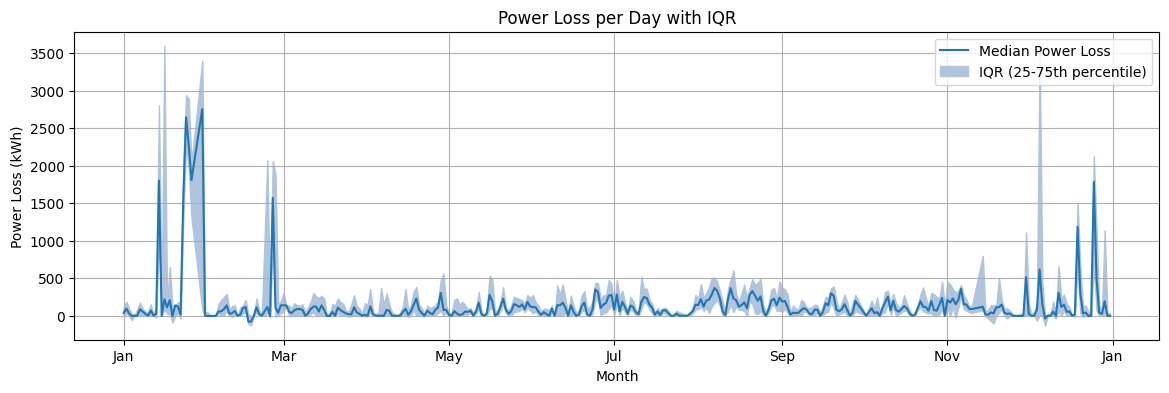

In [166]:
# Calculate the median, 25th percentile (Q1) and 75th percentile (Q3) per day
daily_stats = df.groupby(df.index.date)['loss'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
daily_stats.columns = ['median', 'Q1', 'Q3']

# Convert the index into a datetime object to format the months

daily_stats.index = pd.to_datetime(daily_stats.index)

# Plot the line graph
plt.figure(figsize=(14, 4))
plt.plot(daily_stats.index, daily_stats['median'], label='Median Power Loss')

# Fill the interquartile range (IQR) between Q1 and Q3
plt.fill_between(daily_stats.index, daily_stats['Q1'], daily_stats['Q3'], color='#B0C4DE', alpha=1, label='IQR (25-75th percentile)')

# Format the X-axis to show months with the first three letters
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Power Loss (kWh)')
plt.title('Power Loss per Day with IQR')

# Add the legend
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


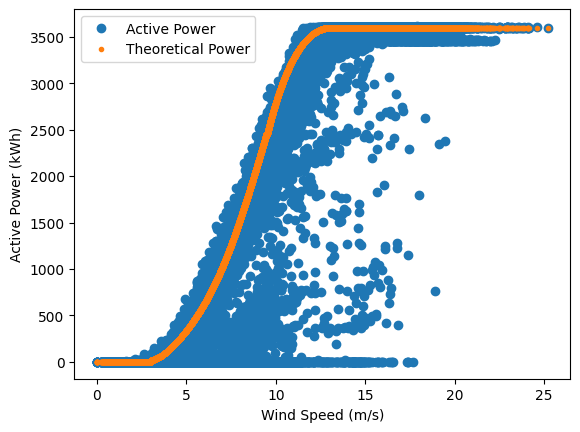

In [167]:
# Plot the Active Power data
ax = df.plot(x='wind_speed', y='active_power', xlabel = 'Wind Speed (m/s)', ylabel = 'Active Power (kWh)', style='o', label = 'Active Power')

# Plot the theoretical power data
df.plot(x='wind_speed', y='theor_power', xlabel = 'Wind Speed (m/s)', ylabel = 'Active Power (kWh)', style='.', ax=ax, label = 'Theoretical Power')

# Save the graphic
plt.savefig('active_power_vs_wind_speed.png', dpi = 600)



In [168]:
# Create intervals to plot active power and theoretical power as lines
interval = np.arange(0.25,26,0.5)
df.groupby(pd.cut(df['wind_speed'], interval)).median().head(10)

<ipython-input-168-9f0404cef0d3>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['wind_speed'], interval)).median().head(10)


,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
wind_speed,,,,,,,
"(0.25, 0.75]",0.000000,0.602417,0.000000,157.224503,9.0,5.0,0.000000
"(0.75, 1.25]",0.000000,1.027681,0.000000,179.270401,11.0,6.0,0.000000
"(1.25, 1.75]",0.000000,1.519854,0.000000,176.416595,10.0,6.0,0.000000
"(1.75, 2.25]",0.000000,2.013961,0.000000,169.468307,10.0,6.0,0.000000
"(2.25, 2.75]",0.000000,2.509326,0.000000,141.979797,10.0,6.0,0.000000
"(2.75, 3.25]",0.000000,3.007773,16.253567,115.259300,10.0,6.0,0.000000
"(3.25, 3.75]",13.196645,3.495518,51.499625,99.582088,11.0,6.0,31.955498
"(3.75, 4.25]",88.988007,4.011401,126.349882,89.165749,11.0,6.0,38.089168
"(4.25, 4.75]",174.363495,4.496426,221.243610,79.324600,12.0,7.0,48.497248


<ipython-input-169-55e2d87d58bd>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['wind_speed'], interval)).mean().plot(


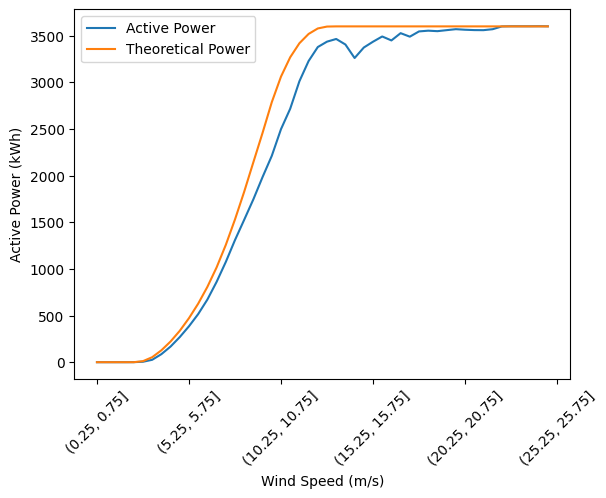

In [169]:
df.groupby(pd.cut(df['wind_speed'], interval)).mean().plot(
    y=['active_power', 'theor_power'],
    rot=45,
    xlabel='Wind Speed (m/s)',
    ylabel='Active Power (kWh)',
    label=['Active Power', 'Theoretical Power']
)

# Save the graphic
plt.savefig('active_power_vs_wind_speed_interval.png', dpi = 600)

plt.legend()


<ipython-input-170-adfe87f3e7f0>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['wind_speed'], interval)).mean().plot(


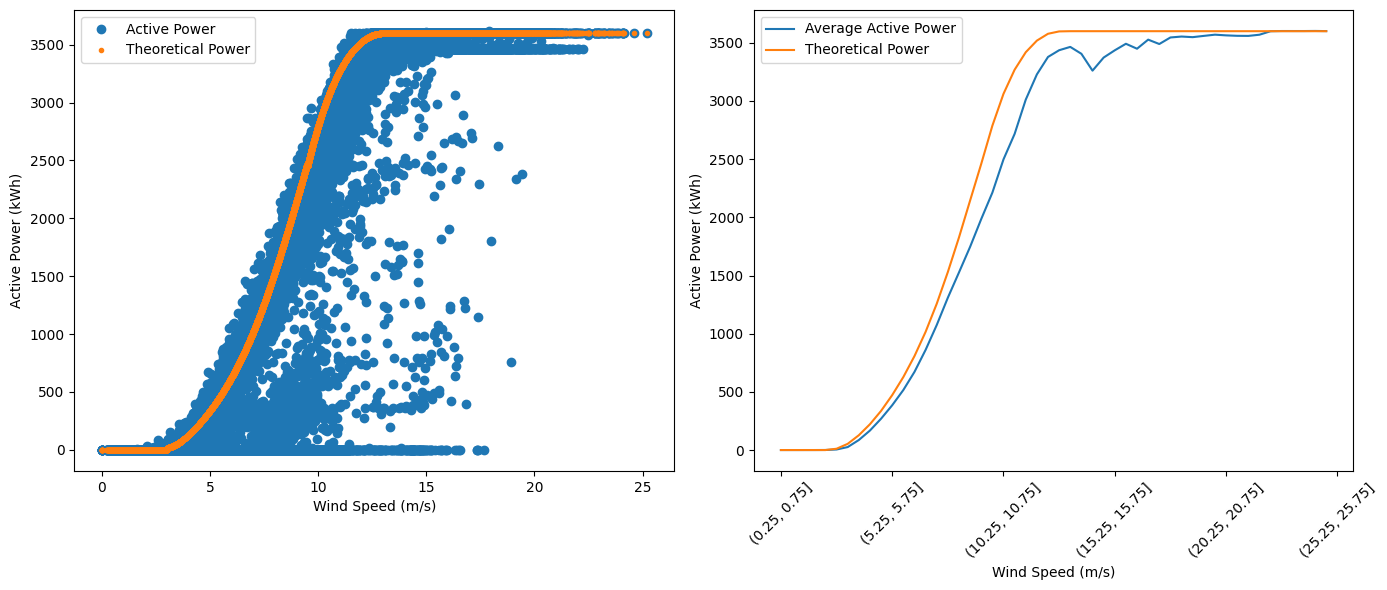

In [170]:
# Create subplots for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Scatter plot of Active Power and Theory Power against Wind Speed
ax = df.plot(x='wind_speed', y='active_power', xlabel='Wind Speed (m/s)', ylabel='Active Power (kWh)', style='o', ax=ax1, label='Active Power')
df.plot(x='wind_speed', y='theor_power', xlabel='Wind Speed (m/s)', ylabel='Active Power (kWh)', style='.', ax=ax1, label='Theoretical Power')

# Plot 2: Grouped mean plot by wind speed intervals
df.groupby(pd.cut(df['wind_speed'], interval)).mean().plot(
    y=['active_power', 'theor_power'],
    rot=45,
    xlabel='Wind Speed (m/s)',
    ylabel='Active Power (kWh)',
    label=['Average Active Power', 'Theoretical Power'],
    ax=ax2
)

# Ensure the legend appears
ax1.legend()
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


<ipython-input-171-8f59696860d5>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df['wind_speed'], interval))


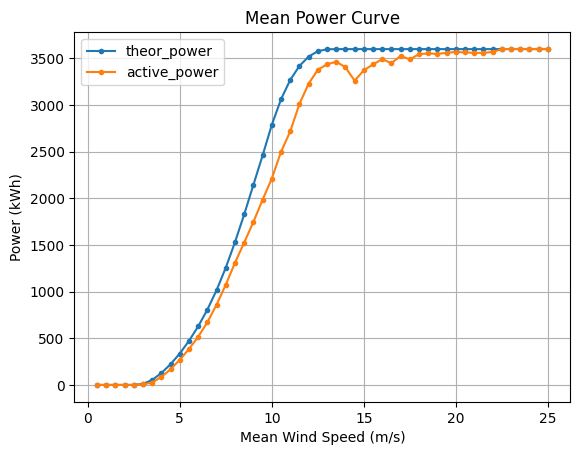

In [171]:
# Function to plot the mean power curve
def mean_power_curve(df):
    # Group by wind speed using the interval
    groups = df.groupby(pd.cut(df['wind_speed'], interval))

    mean_speed = []
    for key, item in groups:
        # Get keys from groupby method
        c = str(key)  # Use str() instead of np.str (np.str is deprecated)
        string = c[1:-1]  # Strip parentheses from the string
        string = string.split(', ')  # Split into bounds
        bounds = [float(i) for i in string]  # Convert bounds to float
        mean = np.mean(bounds)  # Compute mean of the bounds
        mean_speed.append(mean)  # Append the mean speed

    # Take average of the grouped data
    df_mean_speed = groups.mean()

    # Add the computed mean wind speed to the dataframe
    df_mean_speed['mean_speed'] = mean_speed

    # Plot the mean power curve
    df_mean_speed.plot(x='mean_speed', y=['theor_power', 'active_power'], style='.-')

# Call the function to plot the graph
mean_power_curve(df)

# Add title and other details after plotting
plt.title('Mean Power Curve')
plt.xlabel('Mean Wind Speed (m/s)')
plt.ylabel('Power (kWh)')
plt.grid(True)
plt.show()


In [172]:
# We find negative active power (< 0 kWh) in the data. In Physics, negative
# power is normal, means losing power due to friction. Neither we know it is
# physically true nor it is erroneous records, we do not want to predict
# negative power. So we will remove it first.

df2 = df.copy()

# Remove negative active power
df_outlier_removed = df2[df2.active_power>0]

df_outlier_removed

#Outliers
#We identify some events when there is power produced by the turbine although
# wind speed is below threshold 3 m/s.

# When wind speed is below 3.5, there is still power
df_outlier_removed[(df_outlier_removed.wind_speed<=3.5) & (df_outlier_removed.active_power!=0)]


,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
date,,,,,,,
2018-01-01 12:30:00,41.947239,3.253968,29.286956,233.065903,12,1,-12.660283
2018-01-03 15:30:00,7.347679,3.011371,16.374212,238.690598,15,1,9.026533
2018-01-03 15:50:00,12.344200,3.246252,28.731272,238.076508,15,1,16.387072
2018-01-05 07:30:00,13.934310,3.227394,27.413258,62.523109,7,1,13.478948
2018-01-05 08:10:00,22.780531,3.310203,33.624574,74.864113,8,1,10.844043
...,...,...,...,...,...,...,...
2018-12-18 01:40:00,6.939387,3.133558,21.700877,49.132389,1,12,14.761490
2018-12-21 05:40:00,20.305180,2.648756,0.000000,175.433197,5,12,-20.305180
2018-12-21 05:50:00,4.730608,2.157747,0.000000,172.074402,5,12,-4.730608


<ipython-input-173-b02ad11a3685>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_zero_power.resample('M').count().active_power.plot(kind='bar')


<Axes: xlabel='date'>

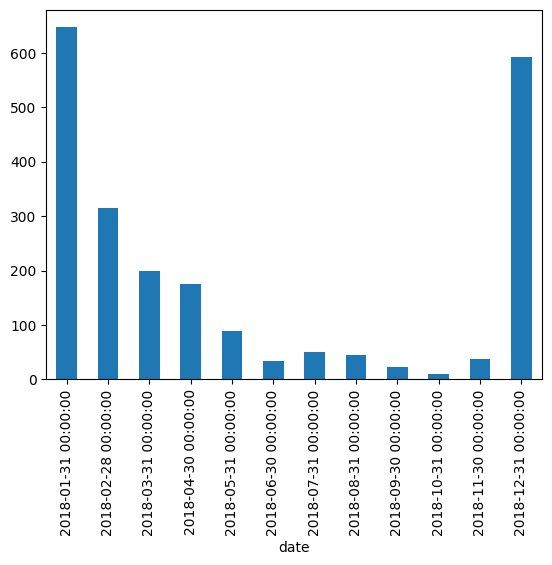

In [173]:
#And we identify some events when there is ZERO power produced although
# wind speed is above 3 m/s and theoretical power is expected to be not ZERO.
# We see these happen most frequently in January and December.

df_zero_power = df[(df.active_power==0) & (df.theor_power!=0) & (df.wind_speed>3.5)]

# Plot the frequency (counts) of ZERO power of every month
df_zero_power.resample('M').count().active_power.plot(kind='bar')



<ipython-input-174-a751c8c69d1e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[(df.active_power>df.theor_power)].resample('M').count().active_power.plot(kind='bar')


<Axes: xlabel='date'>

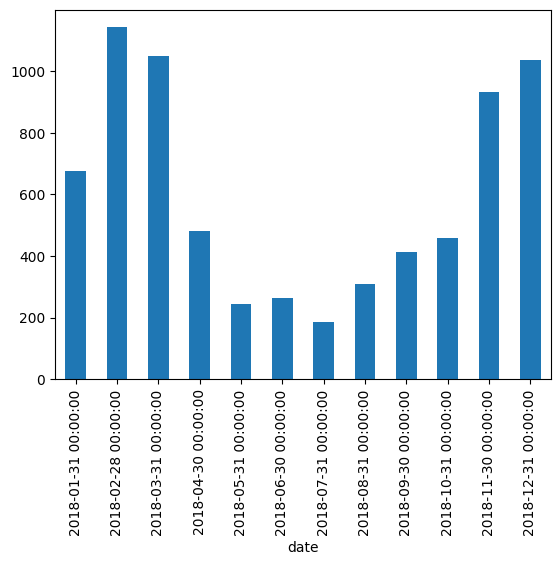

In [174]:
# Interestingly, we can identify some events when active power exceeds
# theoretical power. This is very beneficial, but suspicious because
# active power is often lower than theoretical power.

df[(df.active_power>df.theor_power)].resample('M').count().active_power.plot(kind='bar')



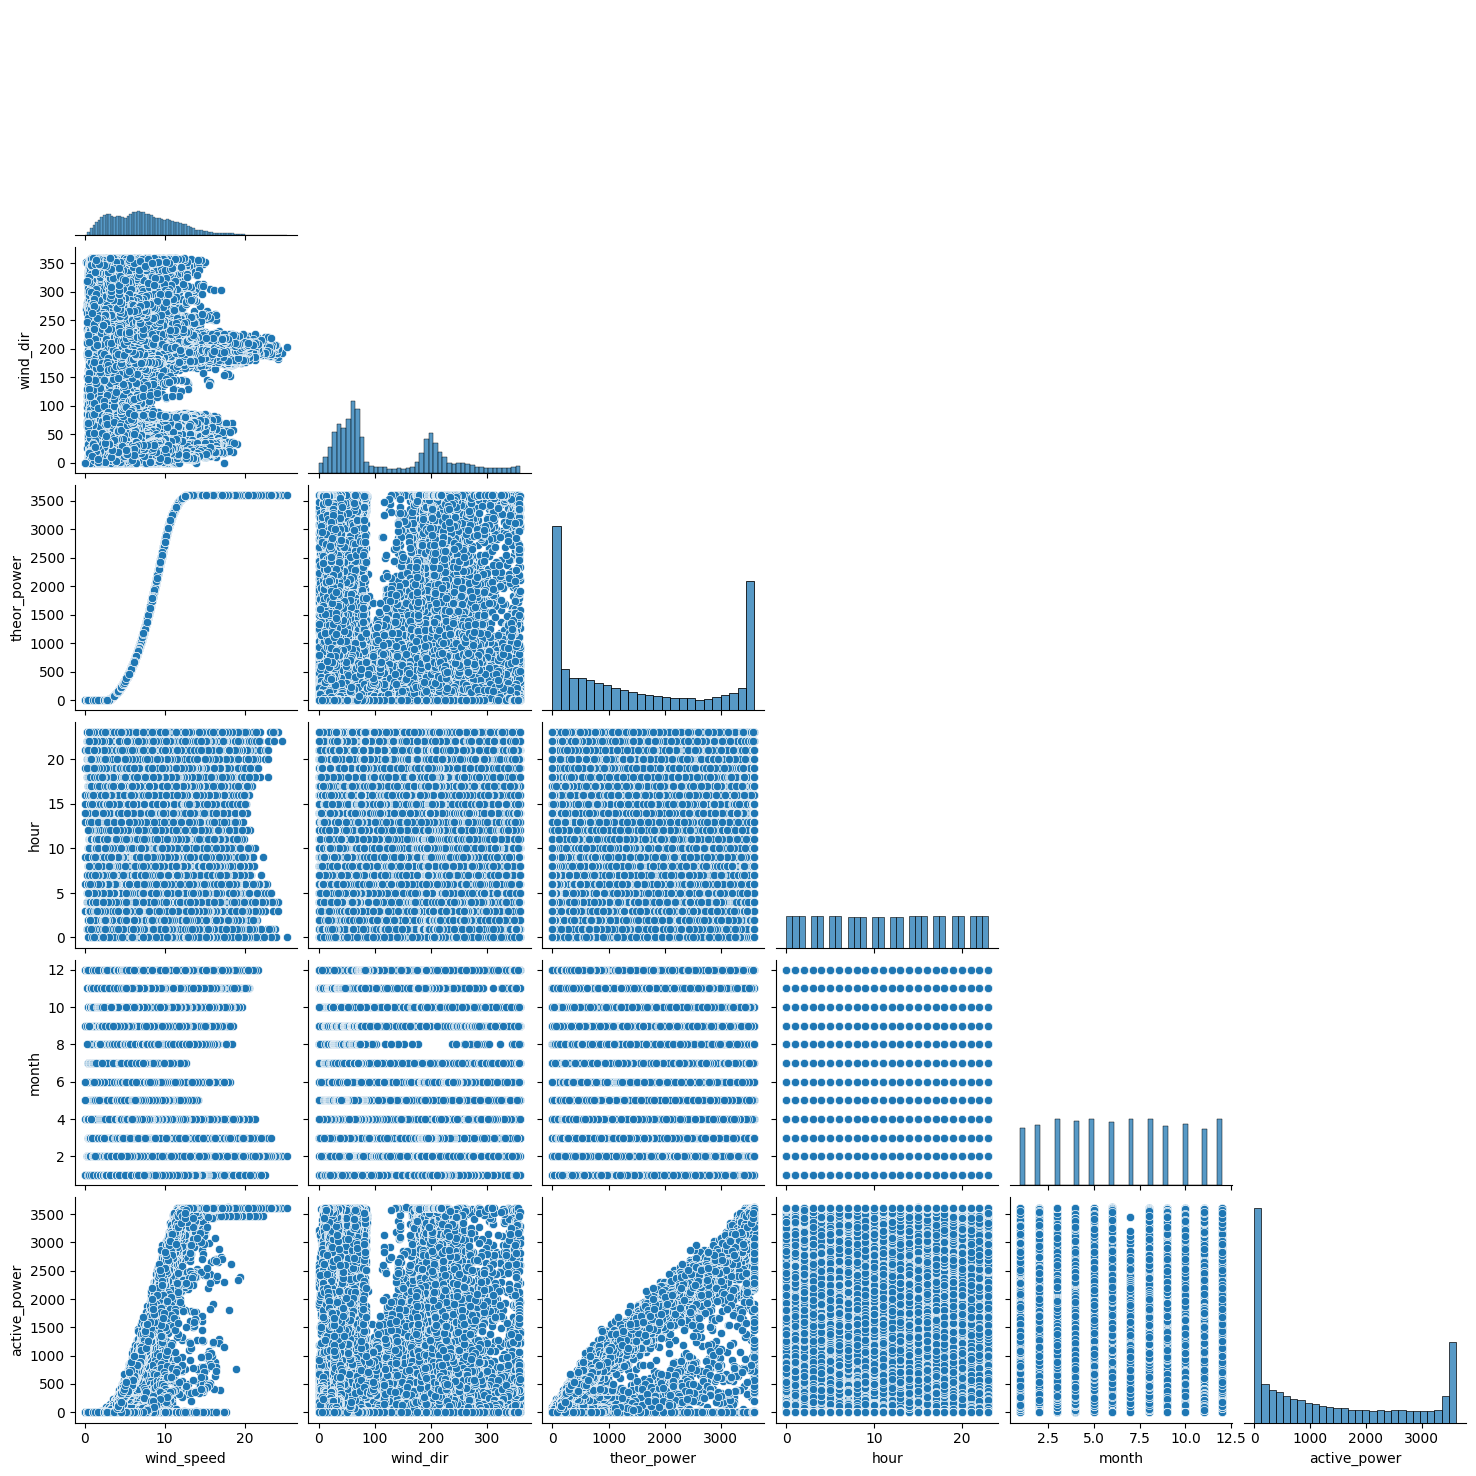

In [175]:
# Plot scatterplot to observe the relation between each variable
sns.pairplot(df, vars=['wind_speed', 'wind_dir', 'theor_power', 'hour', 'month', 'active_power'], corner=True)



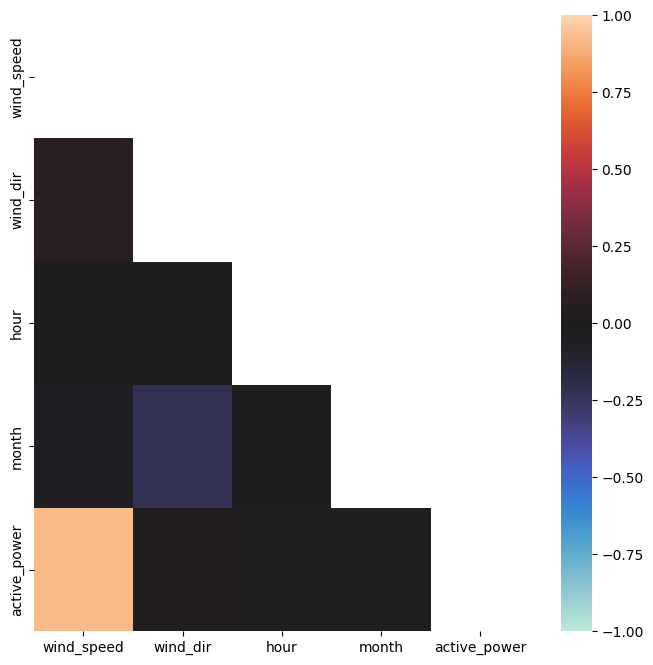

In [176]:
# Plot the correlation matrix between each variable
def corr_heatmap(df):
    plt.figure(figsize=(8,8))

    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap='icefire')

corr_heatmap(df_outlier_removed[['wind_speed', 'wind_dir', 'hour', 'month', 'active_power']])

# Support Vector Machine (SVM)

In [177]:
# We made our first model, SVM, that will model the data without temporal
# information as features (hour and month). We would like to investigate
# "mathematically" the turbine power as a function of wind speed and wind direction.

# Features and target: use only wind direction and wind speed
X = df_outlier_removed[['wind_dir', 'wind_speed']]
y = df_outlier_removed['active_power']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make pipeline
pipe = make_pipeline(StandardScaler(), SVR())

# 5-fold CV
r2_cv = cross_val_score(pipe, X_train, y_train, cv=5)
print(r2_cv)
print(np.mean(r2_cv))

#The 5-fold cross-validation R2 score of our SVM model is 94%.

# Fit SVM model
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

# Train R2
print(f'Train R2: {pipe.score(X_train, y_train)}')

# Test R2, MSE, MAE
print(f'Test R2: {pipe.score(X_test, y_test)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred)}')



[0.94164981 0.93732246 0.93972004 0.94354066 0.94329232]
0.9411050586370242
Train R2: 0.9459030390874197
Test R2: 0.9422862160177913
Test MAE: 159.04878493315968
Test MSE: 92280.41669771016


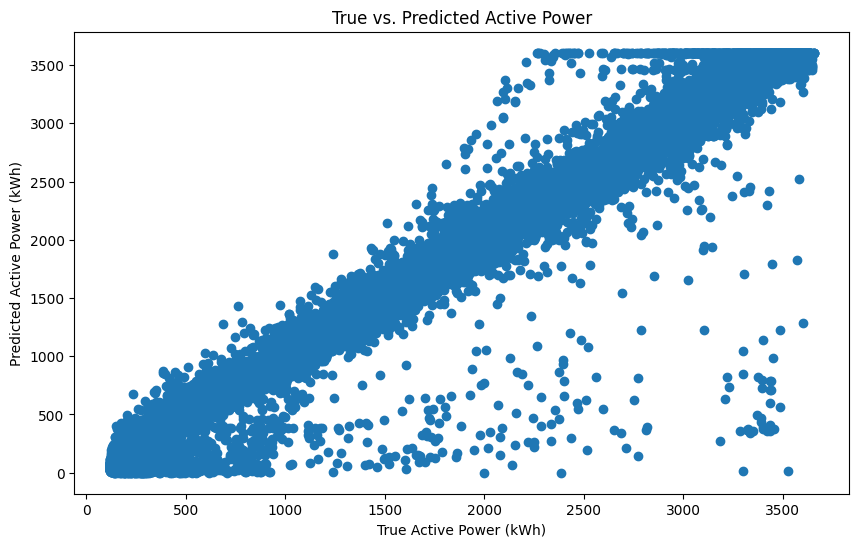

In [178]:
# Plot true vs. predicted power
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
plt.xlabel('True Active Power (kWh)')
plt.ylabel('Predicted Active Power (kWh)')
plt.title('True vs. Predicted Active Power')

# Save the graphic
plt.savefig('true_vs_predicted_power.png', dpi = 600)

plt.show()

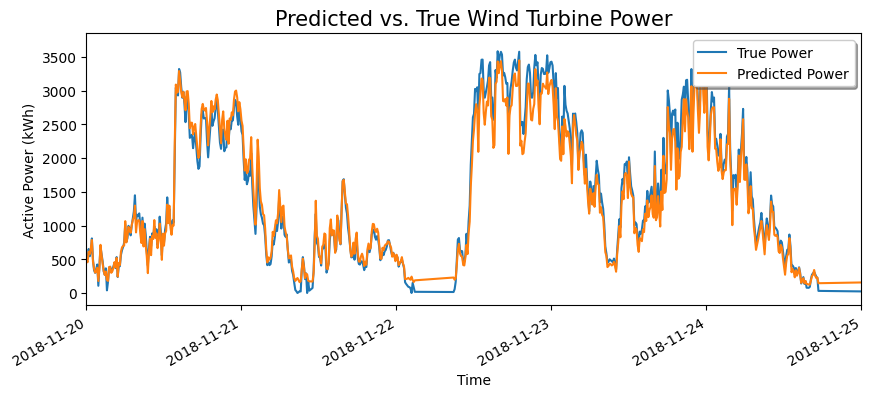

In [186]:
#Predict on time-series

# Entire data
y_pred_all = pipe.predict(X)

# Predicted power into dataframe
y_pred = pd.DataFrame(y_pred_all, columns=['active_power'])
y_pred.index = y.index

y_pred

# True power (blue) vs. predicted power (orange)
t = df_outlier_removed.index
ax = y.plot(figsize=(10,4), xlim=(np.datetime64('2018-11-20'), np.datetime64('2018-11-25')))
y_pred.plot(figsize=(10,4), xlim=(np.datetime64('2018-11-20'), np.datetime64('2018-11-25')), ax=ax)
plt.title('Predicted vs. True Wind Turbine Power', size=15)
plt.ylabel('Active Power (kWh)')
plt.xlabel('Time')

# Customize the legend box: 'upper left', 'upper right', etc., or use bbox_to_anchor for finer control
plt.legend(labels = ['True Power', 'Predicted Power'], loc='upper right', bbox_to_anchor=(1, 1), shadow=True, fancybox=True)

# Save the graphic
plt.savefig('predicted_vs_true_power.png', dpi = 600)

plt.show()

In [188]:
# Let's define the non-linear function (our SVM hyperplane) of Active Power as a
# function of Wind Speed and Wind Direction,

# P=f(ws,wd)

ws = np.linspace(0, 26, 50)
wd = np.linspace(0, 360, 50)
ws, wd = np.meshgrid(ws, wd)

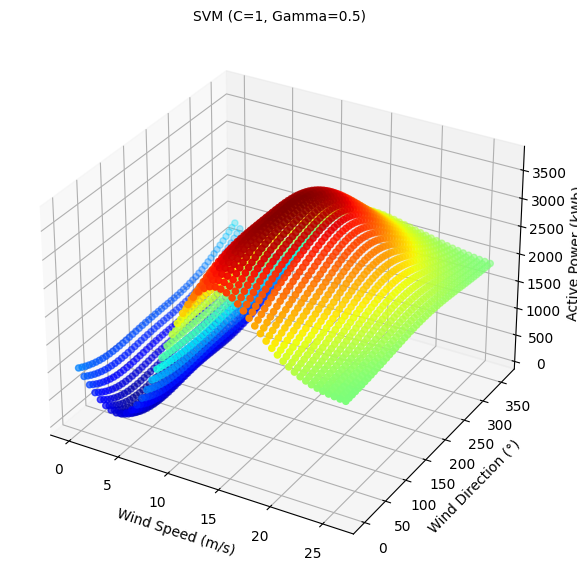

In [189]:
# Prediction space dataframe
X_space = pd.DataFrame({'wind_dir': wd.flatten(), 'wind_speed': ws.flatten()})

y_pred_space = pipe.predict(X_space)

pipe.steps[1][1].get_params()

#{'C': 1.0,
#'cache_size': 200,
# 'coef0': 0.0,
# 'degree': 3,
# 'epsilon': 0.1,
# 'gamma': 'scale',
# 'kernel': 'rbf',
# 'max_iter': -1,
# 'shrinking': True,
# 'tol': 0.001,
# 'verbose': False}

pipe.steps[1][1]._gamma

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(X_space.wind_speed.values, X_space.wind_dir.values, y_pred_space,
             c=y_pred_space, cmap='jet')

# ax.scatter3D(X.wind_speed.values, X.wind_dir.values, y,
#              c='b', alpha=0.2)

ax.set_xlabel('Wind Speed (m/s)', size=10)
ax.set_ylabel('Wind Direction (°)', size=10)
ax.set_zlabel('Active Power (kWh)', size=10)
ax.set_title('SVM (C=1, Gamma=0.5)', size=10)

# Save the graphic
plt.savefig('svm_hyperplane.png', dpi = 600)

# Show the plot
plt.show()


# Light Gradient Boosting Machine

In [190]:
# Tree models The second model, we will use tree models to include temporal
# information as features. We have seen that turbine power also varies with hour
# and month. We will compare 5 tree models and pick the best using 10-fold CV.

# Features and target: now include hour and month as temporal features
X = df_outlier_removed[['wind_dir', 'wind_speed', 'hour', 'month']]
y = df_outlier_removed['active_power']

trees = [DTRegressor(), RFRegressor(), XGBRegressor(), Ada(), LGBMRegressor()]

for tree in trees:
    # Make pipeline
    pipe = make_pipeline(StandardScaler(), tree)

    # 10-fold CV
    r2_cv = cross_val_score(pipe, X_train, y_train, cv=10)
    print(f'{pipe.steps[1][1]}: {np.mean(r2_cv)}')



DecisionTreeRegressor(): 0.921230705761935
RandomForestRegressor(): 0.9538665698562226
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...): 0.9547328309312993
AdaBoostRegressor(): 0.9159942891855453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
Yo

From the model comparison, Light Gradient Boosting Machine (LGBM) achieves the highest cross-validation R2 score of all tree models (scored 96%). It is also 2% higher than R2 score of our SVM.